In [1]:
from fastai.vision import *

from adapter import loss_func, get_y_func, load_voc, has_person, json_to_paths, create_split_func, YoloCategoryList, \
    ApAt50
from models import Darknet
from train import hyp
from utils import torch_utils

In [2]:
images = load_voc()

In [3]:
# Build lists of positive and negative samples
positive_samp = [img for img in images.values() if has_person(img)]
negative_samp = [img for img in images.values() if not has_person(img)]
f"{len(positive_samp)}; {len(negative_samp)}"

'8566; 12937'

In [4]:
# Truncate negative samples to be roughly same length as positive
negative_samp = negative_samp[:len(positive_samp)]
len(negative_samp)

8566

In [5]:
# Combine sample sets back together
samples = positive_samp  # + negative_samp

In [6]:
# Load the model
img_size = (352, 608)
device = 'cuda:0'
arc = 'default'
cfg = 'cfg/yolov3-tiny-anchors.cfg'
weights = 'weights/best.pt'
device = torch_utils.select_device(device, apex=False, batch_size=64)
model = Darknet(cfg, img_size=img_size, arc=arc).to(device)
model.arc = 'default'
model.nc = 1  # num classes
model.hyp = hyp
model.load_state_dict(torch.load(weights, map_location=device)['model'])

# Build the paths and pass them to the FastAI ObjectItemList
posix_paths = json_to_paths(samples)
lst = ObjectItemList(posix_paths, label_cls=YoloCategoryList)
YoloCategoryList.anchors = [model.module_list[l].anchors for l in model.yolo_layers]
YoloCategoryList.img_size = img_size

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2070 with Max-Q Design', total_memory=7982MB)



In [7]:
# Turn all this into a FastAI DataBunch so we can train
data = (lst
        .split_by_valid_func(create_split_func(samples))
        .label_from_func(partial(get_y_func, images))
        .transform(
    get_transforms(),
    tfm_y=True,
    size=img_size,
    resize_method=ResizeMethod.PAD,
    padding_mode='zeros'
)
        .databunch(bs=16, collate_fn=bb_pad_collate))

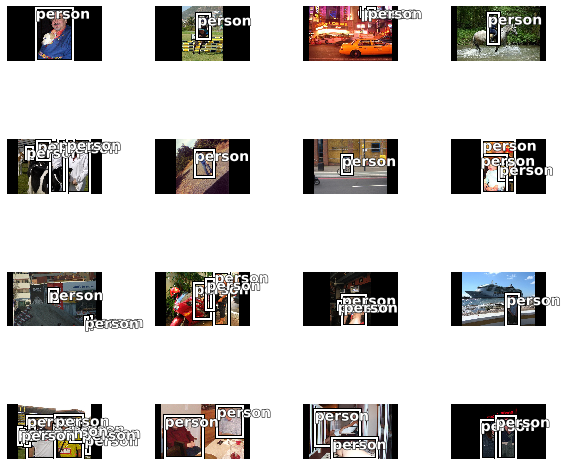

In [8]:
# Show the images so we can visually validate
data.show_batch(rows=4, ds_type=DatasetType.Valid, figsize=(8, 8))

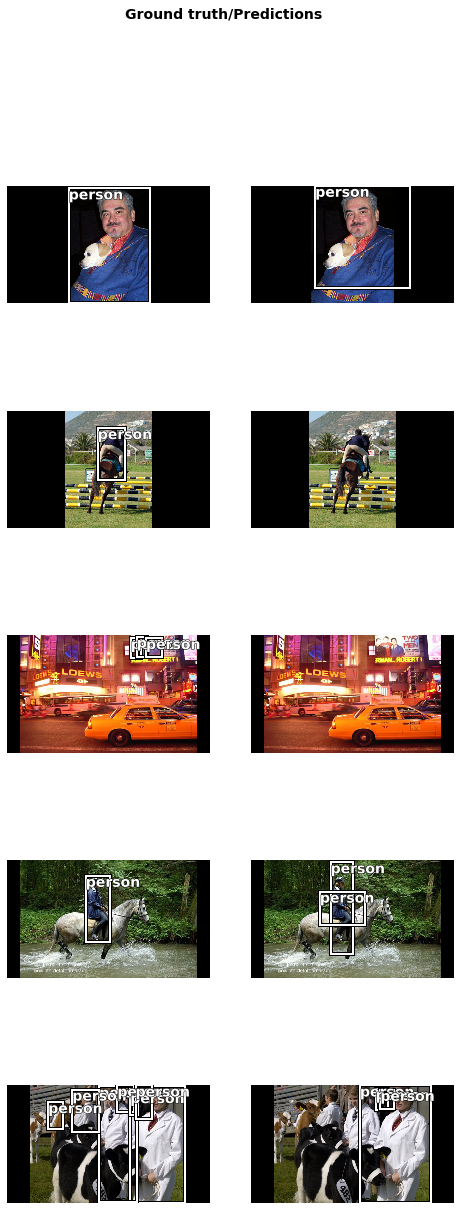

In [9]:
# Finally we have everything we need to make a learner
metrics = [ApAt50()]
learner = Learner(data, model, loss_func=partial(loss_func, model), metrics=metrics)
learner.show_results(rows=5)

In [10]:
# test custom metrics
epochs = 1
callbacks = []
cb_handler = CallbackHandler(callbacks, metrics)
pbar = master_bar(range(epochs))
cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)
val_loss = validate(learner.model, learner.data.valid_dl, loss_func=learner.loss_func,
                    cb_handler=cb_handler)

In [11]:
val_loss

1.177353

In [12]:
lr_find(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


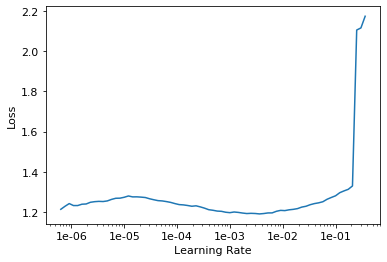

In [13]:
learner.recorder.plot()

In [14]:
fit_one_cycle(learner, 1, max_lr=1e-3)

epoch,train_loss,valid_loss,ap_at50,time
0,0.825479,0.801451,0.292675,01:07


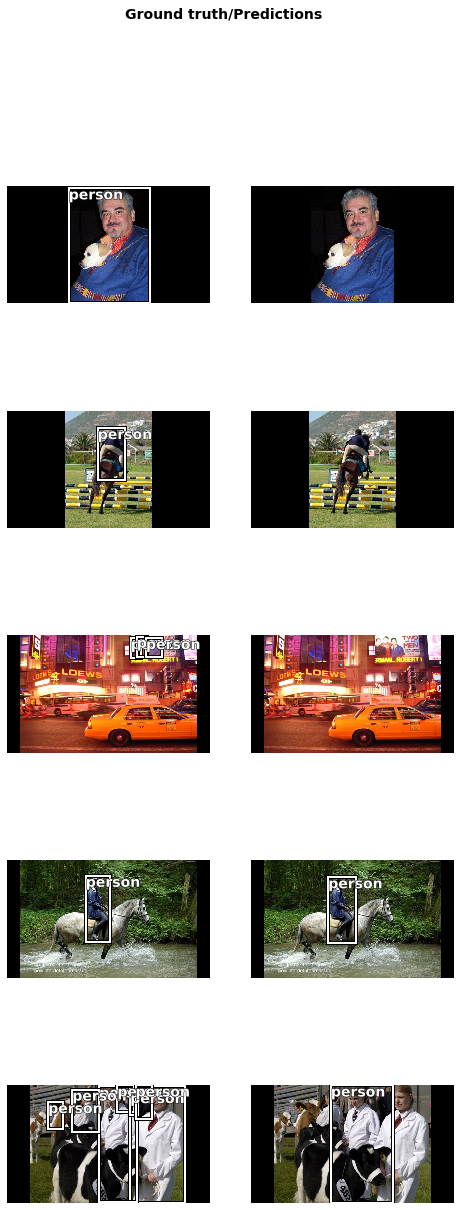

In [15]:
learner.show_results(rows=5)

In [17]:
lr_find(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


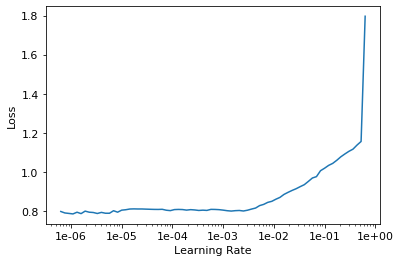

In [18]:
learner.recorder.plot()

In [19]:
fit_one_cycle(learner, 1, max_lr=1e-4)

epoch,train_loss,valid_loss,ap_at50,time
0,0.772506,0.778109,0.359672,01:08


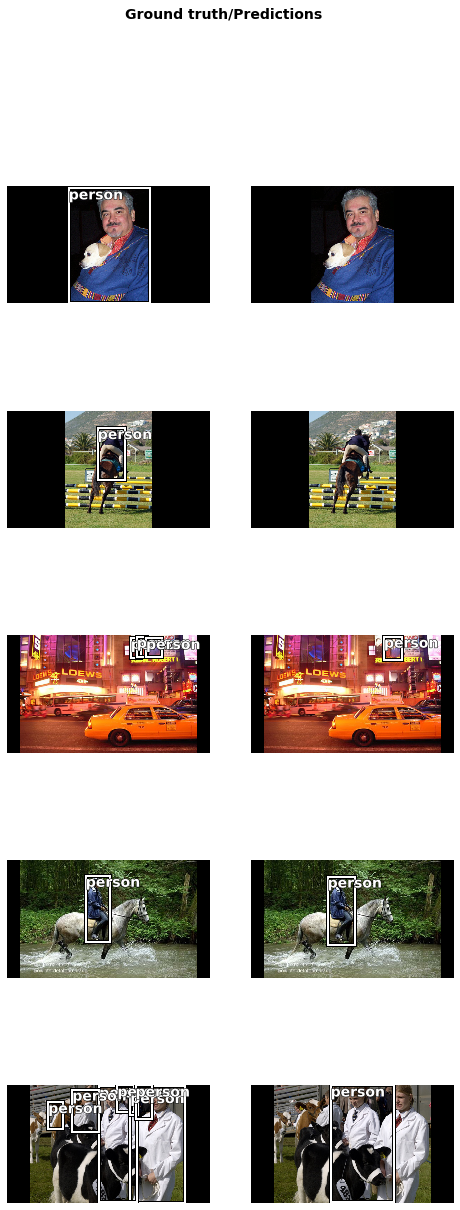

In [20]:
learner.show_results(rows=5)

In [21]:
lr_find(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


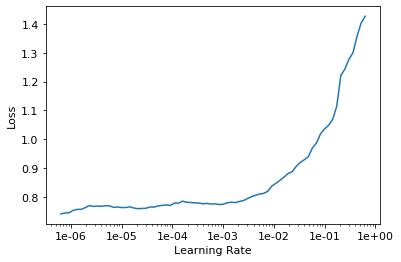

In [22]:
learner.recorder.plot()

In [23]:
learner.unfreeze()

In [24]:
lr_find(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


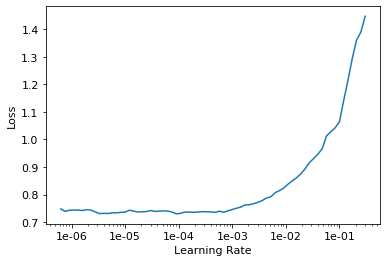

In [25]:
learner.recorder.plot()

In [34]:
learner.model

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (Conv2d): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (Conv2d): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [41]:
from fastai.callbacks import hooks
hooks.model_summary(learner)

Darknet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 352, 608]       432        True      
______________________________________________________________________
BatchNorm2d          [16, 352, 608]       32         True      
______________________________________________________________________
LeakyReLU            [16, 352, 608]       0          False     
______________________________________________________________________
MaxPool2d            [16, 176, 304]       0          False     
______________________________________________________________________
Conv2d               [32, 176, 304]       4,608      True      
______________________________________________________________________
BatchNorm2d          [32, 176, 304]       64         True      
______________________________________________________________________
LeakyReLU            [32, 176, 304]       0          False     
______________________________________________________

In [46]:
learner.lr_range(slice(1e-6, 1e-4))

ZeroDivisionError: division by zero

In [47]:
learner.layer_groups

[Sequential(
   (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): LeakyReLU(negative_slope=0.1, inplace=True)
   (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): LeakyReLU(negative_slope=0.1, inplace=True)
   (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): LeakyReLU(negative_slope=0.1, inplace=True)
   (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),